# 載入所需套件

In [1]:
import requests
from bs4 import BeautifulSoup
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

#設定字體和解決圖像中文顯示問題
plt.rcParams['font.sans-serif']=['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus']=False

# 定義爬取六都市長候選人連結網址函數

In [2]:
def candidate_list():
    url='http://db.cec.gov.tw/histQuery.jsp?voteCode=20181101A1B1&qryType=ctks'
    headers={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.100 Safari/537.36'}
    #timeout:設定的秒數時間後停止等待回應
    response=requests.get(url,headers=headers,timeout=5)
    soup=BeautifulSoup(response.text,'html.parser')
    data=soup.select('tr.data')
    
    links=['http://db.cec.gov.tw/{}'.format(e.select('a')[-1]['href']) for e in data]
    party=[e.select('td')[-5].text for e in data]
    name=[e.select('td')[-9].text for e in data]
    
    party_df=pd.DataFrame({
    'NAME':name,
    'PARTY':party
    })
    
    return links,party_df

# 定義爬取六都市長候選人得票數據資料函數

In [3]:
def value_df(links):
    value_dfs,top5_dfs=[],[]    
    
    for link in links:
        value_df=pd.read_html(link)[0]
        value_df.columns=value_df.iloc[0,:]
        value_df=value_df.iloc[1:,:]
        value_df.columns=['LOCATION','NAME','NUMBER','VOTES','PERCENT']
        value_df['VOTES']=value_df['VOTES'].astype(int)

        percent=value_df['PERCENT'].values.tolist()

        for i in range(len(percent)):
            percent[i]=percent[i].strip('%')

        value_df['PERCENT']=percent

        value_df.sort_values(by=['PERCENT'],ascending=False,inplace=True)
        value_df.reset_index(drop=True,inplace=True)
        top5_df=value_df.iloc[:5,:]
        value_dfs.append(value_df)
        top5_dfs.append(top5_df)
    
    value_dfs=pd.concat(value_dfs,ignore_index=True)
    top5_dfs=pd.concat(top5_dfs,ignore_index=True)
    value_dfs=value_dfs.merge(party_df,on='NAME')
    top5_dfs=top5_dfs.merge(party_df,on='NAME')
    
    return value_dfs,top5_dfs

# 定義處理地圖資料和數據資料合併函數

In [4]:
def map_df():
    #處理地圖資料
    town_shp=gpd.read_file('./行政區域界線圖資/TOWN_MOI_1080726.shp',encoding='utf-8')
    locations=[]
    countrynames=town_shp['COUNTYNAME'].values.tolist()
    townnames=town_shp['TOWNNAME'].values.tolist()

    for countryname,townname in zip(countrynames,townnames):
        locations.append(countryname+townname)
    town_shp['LOCATION']=locations
    
    #地圖資料和數據資料合併
    merge_df=town_shp.merge(value_dfs,on='LOCATION')
    top5_merge_df=town_shp.merge(top5_dfs,on='LOCATION')
    top5_merge_df['centroid']=top5_merge_df['geometry'].centroid
    
    return merge_df,top5_merge_df

# 定義繪製六都市長候選人得票率地圖函數

In [5]:
def candidate_map(country,name):
    #處理'台'簡體字問題
    if '台' in country:
        country=country.replace('台','臺')
    
    merge_df_c=merge_df[(merge_df['COUNTYNAME']==country)&(merge_df['NAME']==name)]
    top5_merge_df_c=top5_merge_df[(top5_merge_df['COUNTYNAME']==country)&(top5_merge_df['NAME']==name)]
    merge_df_c.reset_index(drop=True,inplace=True)
    
    #設計針對不同政黨調整顏色
    if merge_df_c['PARTY'][0]=='民主進步黨':
        cmap='Greens'
    elif merge_df_c['PARTY'][0]=='中國國民黨':
        cmap='Blues'
    else:
        cmap='Greys'
        
    vmin=merge_df_c['PERCENT'].min()
    vmax=merge_df_c['PERCENT'].max()
    sm=plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vmin=vmin,vmax=vmax))
    props=dict(boxstyle='round',facecolor='linen',alpha=0.9)
    
    fig,ax=plt.subplots(1,figsize=(15,15))
    merge_df_c.plot(edgecolor='black',ax=ax,column='PERCENT',cmap=cmap)
    
    #處理高雄市外島行政區超出範圍問題
    if country=='高雄市':
        ax.set_xlim(120.1,121.1)
        ax.set_ylim(22.4,23.5)

    ax.axis('off')
    ax.set_title('2018年{}長選舉{}前五名得票率(%)地區'.format(country,name),fontsize=20)
    for point in top5_merge_df_c.iterrows():
        ax.text(point[1]['centroid'].x,
                point[1]['centroid'].y,
                point[1]['TOWNNAME']+'{}%'.format(point[1]['PERCENT']),
                horizontalalignment='center',
                fontsize=12,
                bbox=props)  
   
    #解決色條棒圖形長度問題(size:寬度) 
    divider=make_axes_locatable(ax)
    cax=divider.append_axes('right',size='3%')
   
    cbar=plt.colorbar(sm,cax=cax)
    cbar.ax.set_title('得票率(%)',fontsize=15)

# 爬取六都市長候選人連結網址

In [6]:
links,party_df=candidate_list()

# 爬取六都市長候選人得票數據資料

In [7]:
value_dfs,top5_dfs=value_df(links)

# 數據資料和地圖資料合併結果

In [8]:
merge_df,top5_merge_df=map_df()

# 繪製指定直轄市、候選人得票率地圖

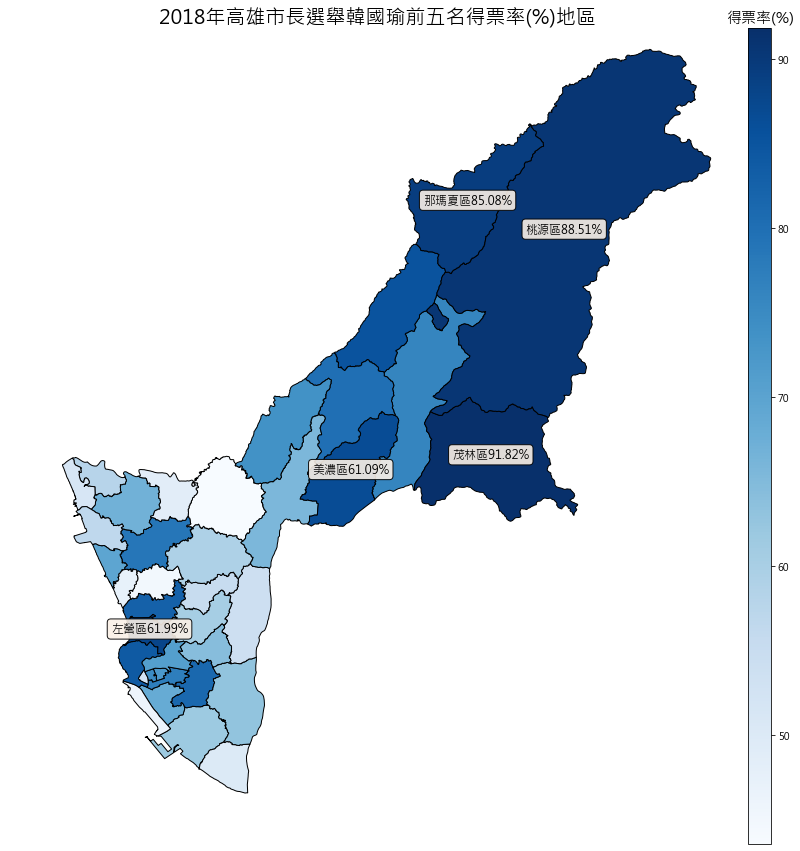

In [9]:
candidate_map('高雄市','韓國瑜')

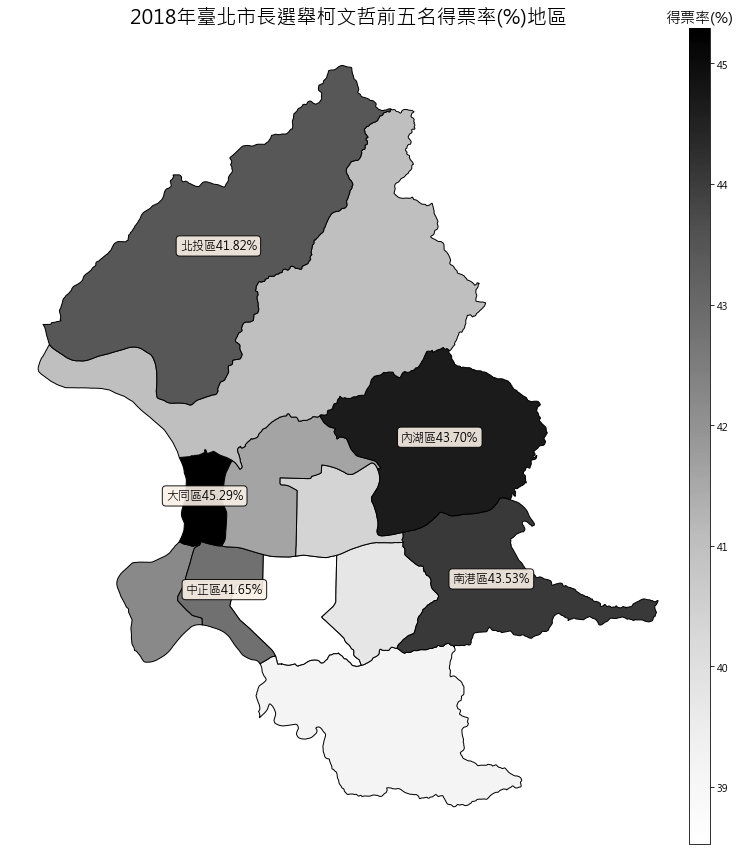

In [10]:
candidate_map('台北市','柯文哲')

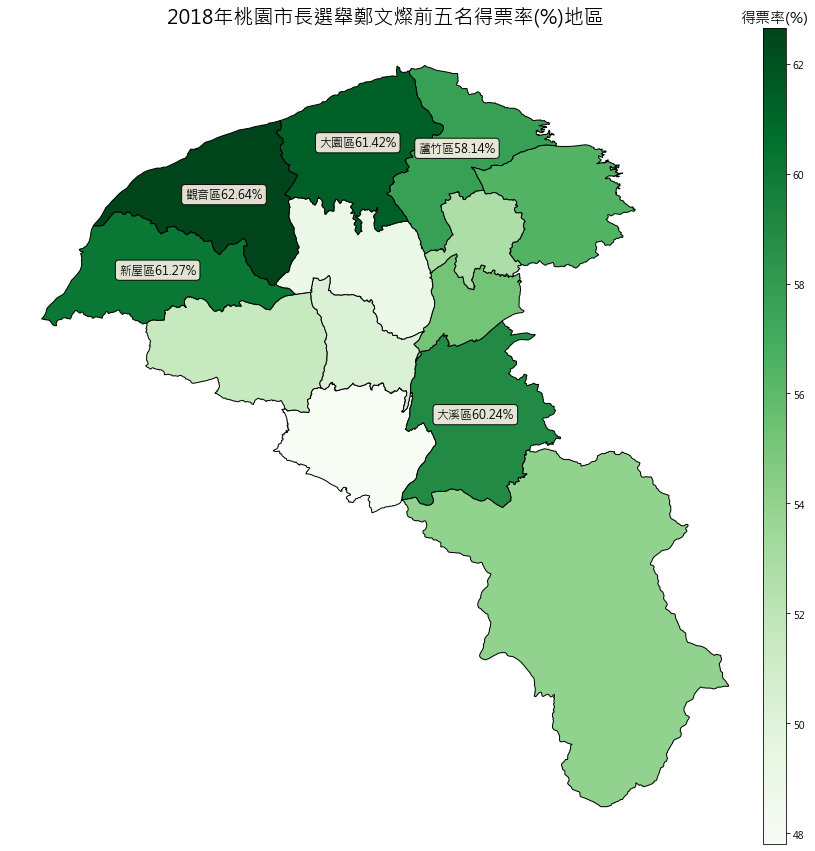

In [11]:
candidate_map('桃園市','鄭文燦')